# Imports

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Pre-Processing

In [2]:
# Load and combine data
PATH_TO_FILE_1 = "../raw data/aapl_2016_2020.csv"
PATH_TO_FILE_2 = "../raw data/aapl_2021_2023.csv"
half_1 = pd.read_csv(PATH_TO_FILE_1, low_memory=False)
half_2 = pd.read_csv(PATH_TO_FILE_2, low_memory=False)
df = pd.concat([half_1, half_2], ignore_index=True)
df.columns = df.columns.str.strip()

# Option type
option_type = "put"

# Convert Unix timestamps to datetime
df['QUOTE_DATETIME'] = pd.to_datetime(df['[QUOTE_UNIXTIME]'], unit='s')
df['EXPIRE_DATETIME'] = pd.to_datetime(df['[EXPIRE_UNIX]'], unit='s')

# Load underlying price data for volatility computation
underlying_prices = df[['QUOTE_DATETIME', '[UNDERLYING_LAST]']].drop_duplicates().set_index('QUOTE_DATETIME').sort_index()

# Function to compute historical volatility
def historical_volatility(series, window=20):
    return np.sqrt(252) * series.pct_change().rolling(window=window).std()

# Compute 20-day historical volatility
underlying_prices['hist_vol_20d'] = historical_volatility(underlying_prices['[UNDERLYING_LAST]'])
underlying_prices.dropna(inplace=True)

# Merge historical volatility back into main dataframe
df = df.merge(underlying_prices[['hist_vol_20d']], left_on='QUOTE_DATETIME', right_index=True, how='inner')

# Columns to numeric conversion: choose columns based on option type
if option_type == 'call':
    numeric_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', '[C_DELTA]', '[C_GAMMA]', '[C_VEGA]',
                    '[C_THETA]', '[C_RHO]', '[C_BID]', '[C_ASK]']
else:
    numeric_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', '[P_DELTA]', '[P_GAMMA]', '[P_VEGA]',
                    '[P_THETA]', '[P_RHO]', '[P_BID]', '[P_ASK]']

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Calculate mid-price based on option type
if option_type == 'call':
    df['CALL_EQUI_PRICE'] = (df['[C_BID]'] + df['[C_ASK]']) / 2
else:
    df['PUT_EQUI_PRICE'] = (df['[P_BID]'] + df['[P_ASK]']) / 2

# Drop rows with missing essential data (dynamically chosen based on option type)
essential_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', 'hist_vol_20d']
if option_type == 'call':
    essential_cols.append('CALL_EQUI_PRICE')
else:
    essential_cols.append('PUT_EQUI_PRICE')
df.dropna(subset=essential_cols, inplace=True)

# Prepare option data based on the option type
if option_type == 'call':
    option_cols = ['[UNDERLYING_LAST]', '[STRIKE]', '[DTE]', 'hist_vol_20d', 
                   '[C_DELTA]', '[C_GAMMA]', '[C_VEGA]', '[C_THETA]', '[C_RHO]', 'CALL_EQUI_PRICE']
    col_rename = ['underlying_price', 'strike_price', 'days_to_expiry', 'hist_volatility', 
                  'delta', 'gamma', 'vega', 'theta', 'rho', 'equilibrium_price']
    output_file = 'processed_calls_data.csv'
    model_file = 'call-mlp1.h5'
else:
    option_cols = ['[UNDERLYING_LAST]', '[STRIKE]', '[DTE]', 'hist_vol_20d', 
                   '[P_DELTA]', '[P_GAMMA]', '[P_VEGA]', '[P_THETA]', '[P_RHO]', 'PUT_EQUI_PRICE']
    col_rename = ['underlying_price', 'strike_price', 'days_to_expiry', 'hist_volatility', 
                  'delta', 'gamma', 'vega', 'theta', 'rho', 'equilibrium_price']
    output_file = 'processed_puts_data.csv'
    model_file = 'put-mlp1.h5'

option_df = df[option_cols].copy()
option_df.columns = col_rename

# Normalize strike price and compute time to expiry in years
option_df['strike_price'] = option_df['strike_price'] / 1000
option_df['time_to_expiry'] = option_df['days_to_expiry'] / 365
option_df.drop('days_to_expiry', axis=1, inplace=True)

print(option_df.sample(10))

         underlying_price  strike_price  hist_volatility    delta    gamma  \
533658             186.87        0.0150         0.167888 -0.00051  0.00004   
538942             187.88        0.1150         0.160242 -0.03115  0.00135   
343188             199.25        0.1600         0.202018 -0.02745  0.00274   
988550             503.68        0.3250         0.461250 -0.01234  0.00028   
431172             172.50        0.1370         0.358628 -0.00384  0.00083   
340803             200.66        0.0950         0.201364 -0.00074  0.00007   
980753             459.78        0.1450         0.495508 -0.00549  0.00005   
7926               153.05        0.2200         0.541932 -0.99638  0.00000   
908964             174.95        0.1575         0.217232 -0.01468  0.00436   
1526101            165.32        0.2200         0.275178 -0.91880  0.00184   

            vega    theta      rho  equilibrium_price  time_to_expiry  
533658   0.00062 -0.00084 -0.00019              0.010        0.386301

# Hyperparameters

In [3]:
# Hyperparameters
n_units_per_layer = [256, 32, 1]
layers = 3
n_batch = 1024
n_epochs = 50

# Building model

In [4]:
# Prepare data for modeling
X = option_df[['underlying_price', 'strike_price', 'hist_volatility', 'delta', 'gamma', 'vega', 'theta', 'rho', 'time_to_expiry']]
y = option_df['equilibrium_price']


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create model 
model = Sequential()

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add first layer without ativation
model.add(Dense(n_units_per_layer[0], input_shape=(X_train_scaled.shape[1],)))
model.add(Activation('relu'))

# Define Keras MLP model using LeakyReLU in subsequent layers
for i in range(1, layers - 1):
    model.add(Dense(n_units_per_layer[i]))
    model.add(Activation('relu'))

# Add last layer
model.add(Dense(n_units_per_layer[-1]))
model.add(Activation('relu'))

# Learning rate scheduling
def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.1  # reduce LR by 10x every 10 epochs
    return lr

lr_callback = LearningRateScheduler(scheduler)

early_stop = EarlyStopping(
    monitor='val_loss',       # what to monitor
    patience=5,               # how many epochs to wait before stopping
    restore_best_weights=True,  # restores weights from best epoch
    verbose=1
)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

c:\GitHub Repos\CS-4641-Project\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,817 (42.25 KB)

 Trainable params: 10,817 (42.25 KB)

 Non-trainable params: 0 (0.00 B)

# Train model

In [5]:
# Train the model
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=n_batch, validation_split=0.2, verbose=1, callbacks=[lr_callback, early_stop])

# Evaluate the model
loss, mae = model.evaluate(X_test_scaled, y_test)
print(f"Test MAE: {mae}")

# Save the model
model.save(model_file)

Epoch 1/50
969/969 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 633.1345 - mae: 10.7653 - val_loss: 3.6079 - val_mae: 1.1475 - learning_rate: 0.0010
Epoch 2/50
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.9564 - mae: 1.0375 - val_loss: 1.9393 - val_mae: 0.8295 - learning_rate: 0.0010
Epoch 3/50
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.8008 - mae: 0.8041 - val_loss: 1.4760 - val_mae: 0.7213 - learning_rate: 0.0010
Epoch 4/50
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3903 - mae: 0.7015 - val_loss: 1.1909 - val_mae: 0.6442 - learning_rate: 0.0010
Epoch 5/50
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1008 - mae: 0.6176 - val_loss: 0.9681 - val_mae: 0.5713 - learning_rate: 0.0010
Epoch 6/50
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8734 - mae: 0.5421 - val_loss: 0.7398 - val_mae: 0.4787 - learning_rate: 0.0010
Epoch 7/50
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7042 - mae: 0.4771 - val_loss: 0.6127 - val_mae: 0.4342 - learning_rate: 0.0010
Epo

Test MAE: 0.3233755826950073


# Plot the loss

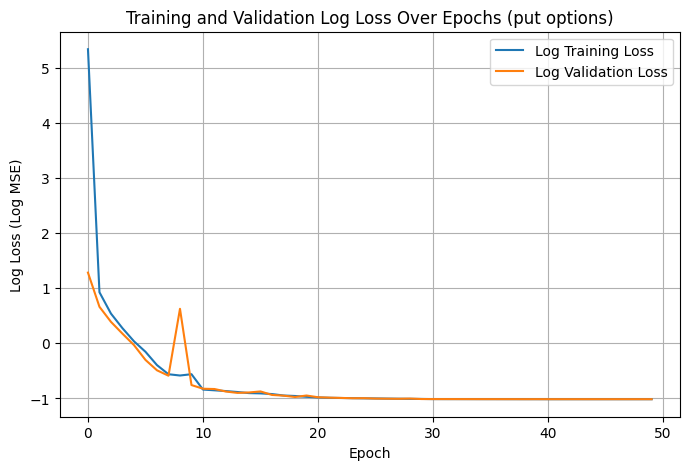

In [6]:
# Plot training and validation loss
plt.figure(figsize=(8,5))

eps = 1e-10  # tiny number to avoid log(0)
plt.plot(np.log(np.array(history.history['loss']) + eps), label='Log Training Loss')
plt.plot(np.log(np.array(history.history['val_loss']) + eps), label='Log Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Log Loss (Log MSE)')
plt.title(f'Training and Validation Log Loss Over Epochs ({option_type} options)')
plt.legend()
plt.grid(True)
plt.show()


Plot the results

9685/9685 ━━━━━━━━━━━━━━━━━━━━ 5s 538us/step


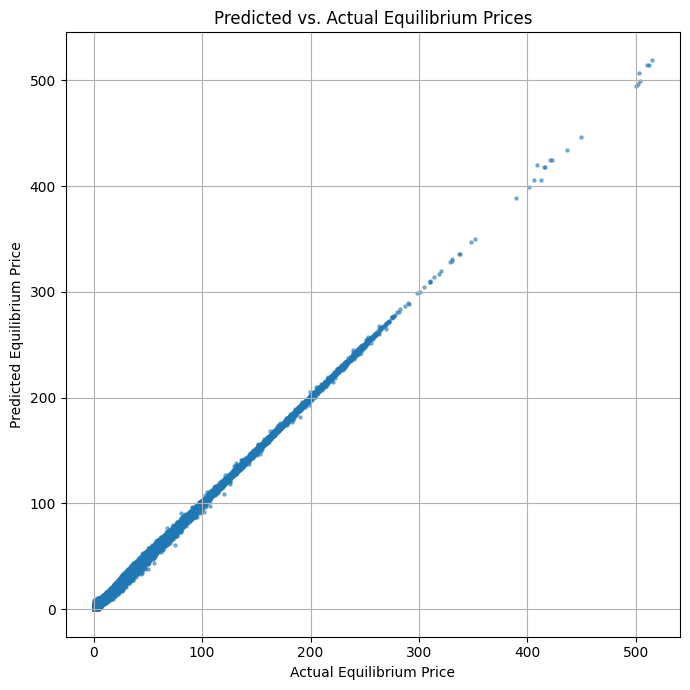

In [7]:
loaded_model = load_model(model_file)

# Predict on test set
y_pred = model.predict(X_test_scaled).flatten()

# Align y_test to numpy array with matching shape
y_test_array = y_test.to_numpy().flatten()

# Plot predicted vs actual
plt.figure(figsize=(7, 7))
plt.scatter(y_test_array, y_pred, s=5, alpha=0.5)
plt.xlabel('Actual Equilibrium Price')
plt.ylabel('Predicted Equilibrium Price')
plt.title('Predicted vs. Actual Equilibrium Prices')
plt.grid(True)
plt.tight_layout()
plt.show()

# Test random entries

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Entry 1059735 - Predicted price: 44.34, Actual price: 44.50
Entry 1048581 - Predicted price: 0.13, Actual price: 0.36
Entry 693175 - Predicted price: 60.42, Actual price: 60.80
Entry 157818 - Predicted price: 0.00, Actual price: 0.05
Entry 1198423 - Predicted price: 20.94, Actual price: 20.25
Entry 1026521 - Predicted price: 54.17, Actual price: 54.40
Entry 484872 - Predicted price: 61.06, Actual price: 61.02
Entry 364861 - Predicted price: 2.26, Actual price: 2.12
Entry 598182 - Predicted price: 29.43, Actual price: 29.77
Entry 1386210 - Predicted price: 43.29, Actual price: 42.98
9685/9685 ━━━━━━━━━━━━━━━━━━━━ 5s 556us/step


C:\Users\Adam Khalil\AppData\Local\Temp\ipykernel_25248\1248329140.py:18: RuntimeWarning: invalid value encountered in divide
  percent_error = 100 * diff / y_true



--- MLP Error Metrics ---
Mean Error: -0.0316
Median Error: -0.0237
Standard Deviation of Error: 0.5998
Mean Absolute Error (MAE): 0.3234
Root Mean Squared Error (RMSE): 0.6007
Mean Absolute Percentage Error (MAPE): nan%
Max Error: 11.0842
Min Error: -14.5768
R² Score: 0.9998


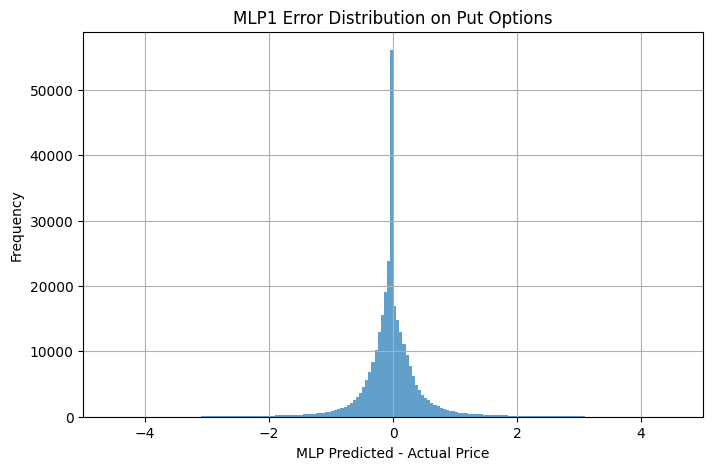

In [13]:
# Test 10 random entries
loaded_model = load_model(model_file)
sample_entries = X.sample(10)
sample_scaled = scaler.transform(sample_entries)
predictions = loaded_model.predict(sample_scaled)

for i, idx in enumerate(sample_entries.index):
    print(f"Entry {idx} - Predicted price: {predictions[i][0]:.2f}, Actual price: {y.loc[idx]:.2f}")

# ---- Full Test Set Error Analysis ----
X_test_scaled = scaler.transform(X_test)
y_pred = loaded_model.predict(X_test_scaled).flatten()
y_true = y_test.values

# Compute differences and errors
diff = y_pred - y_true
abs_error = np.abs(diff)
percent_error = 100 * diff / y_true
abs_percent_error = np.abs(percent_error)

# Metrics
mean_diff = np.mean(diff)
median_diff = np.median(diff)
std_diff = np.std(diff)
mae = abs_error.mean()
rmse = np.sqrt(np.mean(diff**2))
mape = abs_percent_error.mean()
max_diff = diff.max()
min_diff = diff.min()

# Drop NaNs for R² calculation
valid = ~np.isnan(y_pred) & ~np.isnan(y_true)
r2 = r2_score(y_true[valid], y_pred[valid])

# Print metrics
print("\n--- MLP Error Metrics ---")
print(f"Mean Error: {mean_diff:.4f}")
print(f"Median Error: {median_diff:.4f}")
print(f"Standard Deviation of Error: {std_diff:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Max Error: {max_diff:.4f}")
print(f"Min Error: {min_diff:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot histogram of errors
bins = np.arange(-5, 5, 0.05)

plt.figure(figsize=(8, 5))
plt.hist(diff, bins=bins, alpha=0.7)
plt.xlabel("MLP Predicted - Actual Price")
plt.ylabel("Frequency")
plt.title("MLP1 Error Distribution on Put Options")
plt.xlim([-5, 5])
plt.grid(True)
plt.show()